In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
data = pd.read_csv('wine_red.csv',sep = ';')# Get data

# copy the data and normalize
df_scaled = data.copy()
for column in df_scaled.columns:
    df_scaled[column] = df_scaled[column]  / df_scaled[column].abs().max()

df_scaled_shape = df_scaled.shape
df_scaled.head()

# split the data into train and test set
train, test = train_test_split(df_scaled, test_size=0.2, random_state=42, shuffle=True)
print('Train dataset shape:'+str(train.shape))
print('Test dataset shape:'+str(test.shape))
train.head()

Train dataset shape:(1279, 12)
Test dataset shape:(320, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
493,0.547170,0.436709,0.31,0.193548,0.140753,0.319444,0.280277,0.996523,0.867830,0.370,0.778523,0.750
354,0.383648,0.132911,0.40,0.090323,0.108020,0.562500,0.570934,0.987556,0.810474,0.295,0.798658,0.750
342,0.685535,0.246835,0.47,0.116129,0.193126,0.083333,0.048443,0.994530,0.822943,0.375,0.657718,0.750
834,0.553459,0.433544,0.26,0.103226,0.144026,0.222222,0.079585,0.993275,0.827930,0.235,0.630872,0.625
705,0.528302,0.655063,0.15,0.387097,0.119476,0.152778,0.186851,0.995327,0.840399,0.245,0.664430,0.625


In [90]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import numpy as np
from numpy import random

#Define model hyperparameters
batch_size = 100
x_dim  = train.shape[1]
hidden_dim = 10
latent_dim = 6
lr = 1e-3
epochs = 50


# Define custom test Train and test datasets
class train_dataset(Dataset):

    def __init__(self, train):
        # data loading
        state1 = np.float32(train)
        self.st1 = torch.from_numpy(state1)
        self.n_samples1 = state1.shape[0]

    def __getitem__(self, index):
        return self.st1[index]

    def __len__(self):
        return self.n_samples1


class test_dataset(Dataset):

    def __init__(self, test):
        # data loading
        state2 = np.float32(test)
        self.st2 = torch.from_numpy(state2)
        self.n_samples2 = state2.shape[0]

    def __getitem__(self, index):
        return self.st2[index]

    def __len__(self):
        return self.n_samples2


# Dataloader loads data for training
train_loader = DataLoader(dataset = train_dataset(train),batch_size = 100, shuffle = True)
test_loader = DataLoader(dataset = test_dataset(test),batch_size = 100, shuffle = True)


In [91]:
# Define Encoder architecture

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC1     = nn.Linear(input_dim, hidden_dim)
        self.FC2     = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mu   = nn.Linear(hidden_dim, latent_dim)
        self.FC_var  = nn.Linear (hidden_dim, latent_dim)

        self.training = True

    def forward(self, x):
        h_       = F.relu(self.FC1(x))
        h_       = F.relu(self.FC2(h_))
        mean     = self.FC_mu(h_) # mu of simple tractable distribution  Q
        log_var  = self.FC_var(h_)  # sigma of Q

        return mean, log_var
# Define Decoder architecture

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        self.FC1    = nn.Linear(latent_dim, hidden_dim)
        self.FC2    = nn.Linear(hidden_dim, hidden_dim)
        self.FC_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h     = F.relu(self.FC1(x))
        h     = F.relu(self.FC2(h))

        #x_hat = torch.sigmoid(self.FC_output(h))
        x_hat = self.FC_out(h)
        return x_hat

# Define the complete model
encoder = Encoder(input_dim= x_dim, hidden_dim= hidden_dim, latent_dim= latent_dim)
decoder = Decoder(latent_dim= latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

In [92]:
class Model(nn.Module):
    def __init__(self, Encoder=encoder, Decoder=decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparam(self, mean, var):
        epsilon = torch.randn_like(var)# sampling epsilon
        z       = mean + var*epsilon # reparameterization trick
        return z

    def forward(self, x):
        mean, log_var    = self.Encoder(x)
        z                = self.reparam(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)

        return x_hat, mean, log_var


#model = Model(Encoder=encoder, Decoder=decoder)
model = Model()

# Define Loss function and optimizer

from torch.optim import Adam
loss_fun = torch.nn.MSELoss()
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = loss_fun(x_hat, x)
    KLDiv             = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLDiv

optimizer = Adam(model.parameters(), lr=lr)



In [87]:
# Type01-Training pipeline

print("Initiating training process....")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x) in enumerate(train_loader):
        #x = x.view(batch_size, x_dim)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))


Initiating training process....
	Epoch 1 	Average Loss:  0.19118167479832968
	Epoch 2 	Average Loss:  0.1415359115600586
	Epoch 3 	Average Loss:  0.10914118687311808
	Epoch 4 	Average Loss:  0.0857047414779663
	Epoch 5 	Average Loss:  0.06701654394467672
	Epoch 6 	Average Loss:  0.05115667243798574
	Epoch 7 	Average Loss:  0.03364133695761363
	Epoch 8 	Average Loss:  0.018227195491393407
	Epoch 9 	Average Loss:  0.009336739579836528
	Epoch 10 	Average Loss:  0.004675226807594299
	Epoch 11 	Average Loss:  0.0023275419200460114
	Epoch 12 	Average Loss:  0.0012140460746983687
	Epoch 13 	Average Loss:  0.0007199443317949772
	Epoch 14 	Average Loss:  0.0005258076389630635
	Epoch 15 	Average Loss:  0.000457272840042909
	Epoch 16 	Average Loss:  0.0004224411149819692
	Epoch 17 	Average Loss:  0.0003985140938311815
	Epoch 18 	Average Loss:  0.0003872819772611062
	Epoch 19 	Average Loss:  0.00036963816887388627
	Epoch 20 	Average Loss:  0.0003515945561230183
	Epoch 21 	Average Loss:  0.00033339

Start training VAE...
	Epoch 1 complete! 	Average Loss:  0.14018994967142742
	Epoch 2 complete! 	Average Loss:  0.105631023645401
	Epoch 3 complete! 	Average Loss:  0.085298144419988
	Epoch 4 complete! 	Average Loss:  0.06864291548728943
	Epoch 5 complete! 	Average Loss:  0.04797291874885559
	Epoch 6 complete! 	Average Loss:  0.027941418488820393
	Epoch 7 complete! 	Average Loss:  0.015323872715234756
	Epoch 8 complete! 	Average Loss:  0.008733616272608439
	Epoch 9 complete! 	Average Loss:  0.005061315720280011
	Epoch 10 complete! 	Average Loss:  0.002969293147325516
	Epoch 11 complete! 	Average Loss:  0.001787432295580705
	Epoch 12 complete! 	Average Loss:  0.00115418566390872
	Epoch 13 complete! 	Average Loss:  0.0008669235308965047
	Epoch 14 complete! 	Average Loss:  0.0007376163049290578
	Epoch 15 complete! 	Average Loss:  0.0006664695280293624
	Epoch 16 complete! 	Average Loss:  0.0006180932900557916
	Epoch 17 complete! 	Average Loss:  0.0005681644038607677
	Epoch 18 complete! 	Av

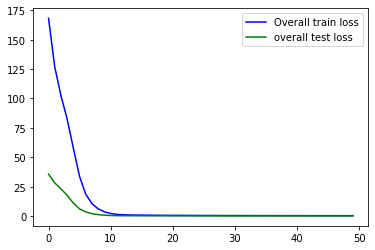

In [93]:
# Type2- Training with Testing pipeline
# Alternative to above Cell

print("Initiating training and testing process....")

def train(dataloader, model, loss_function, optimizer, batch_size, overall_train_loss, epoch):
    model.train()
    for batch_idx, (x) in enumerate(dataloader):
        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_train_loss / (batch_idx*batch_size))
    return overall_train_loss

def test(dataloader, model, loss_function, overall_test_loss):
    model.eval()
    with torch.no_grad():
        for batch_idx, (y) in enumerate(dataloader):
            x_hat, mean, log_var = model(y)
            overall_test_loss += loss_function(y, x_hat, mean, log_var)
    return overall_test_loss

epochs = 50
otrl = []
otel = []
for epoch in range(epochs):
    overall_train_loss = 0
    overall_test_loss = 0
    otrl.append(train(train_loader, model, loss_function, optimizer, batch_size, overall_train_loss,epoch))
    otel.append(test(test_loader, model, loss_function, overall_test_loss))

xc = np.arange(len(otrl))
plt.plot(xc, otrl, '-b', label = 'Overall Train loss')
plt.plot(xc, otel, '-g', label = 'Overall Test loss')
plt.legend()
plt.show()
